Datasets under /kaggle/input: ['flare21-ct-segmentation']
Using base_dir: /kaggle/input/flare21-ct-segmentation
Detected image dir: /kaggle/input/flare21-ct-segmentation/flare21-3d-ct-train/Training Set/TrainingImg
Detected mask dir : /kaggle/input/flare21-ct-segmentation/flare21-3d-ct-train/Training Set/TrainingMask/TrainingMask
Num image volumes: 361
Num mask volumes : 361
Output folders created:
 Axial   -> /kaggle/working/images_axial , /kaggle/working/masks_axial
 Sagittal-> /kaggle/working/images_sagittal , /kaggle/working/masks_sagittal
 Coronal -> /kaggle/working/images_coronal , /kaggle/working/masks_coronal
Processing volume 1/361
Processing volume 2/361
Processing volume 3/361
Processing volume 4/361
Processing volume 5/361
Processing volume 6/361
Processing volume 7/361
Processing volume 8/361
Processing volume 9/361
Processing volume 10/361
Processing volume 11/361
Processing volume 12/361
Processing volume 13/361
Processing volume 14/361
Processing volume 15/361
Processin

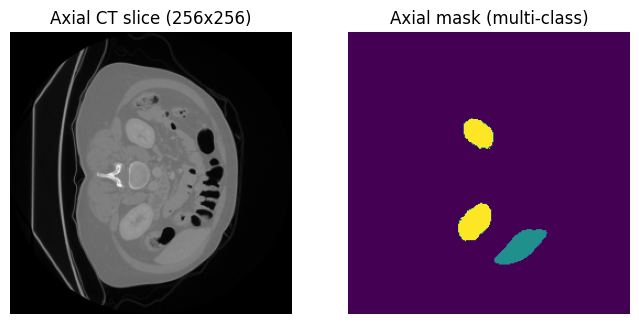

In [1]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import cv2

# -----------------------
# 0. Auto-detect dataset + TrainingImg / TrainingMask paths
# -----------------------

input_root = "/kaggle/input"

datasets = os.listdir(input_root)
print("Datasets under /kaggle/input:", datasets)

assert len(datasets) > 0, "No datasets found under /kaggle/input. Make sure you attached/uploaded your dataset."

# If you have only one dataset attached, use that.
# If you have multiple, you can change this to pick the right one.
dataset_name = datasets[0]
base_dir = os.path.join(input_root, dataset_name)
print("Using base_dir:", base_dir)

train_img_dir = None
train_mask_dir = None

for root, dirs, files in os.walk(base_dir):
    # Look for folders whose path contains "TrainingImg" or "TrainingMask"
    if "TrainingImg" in root and train_img_dir is None:
        train_img_dir = root
    # We want the leaf TrainingMask that actually has the mask files
    if "TrainingMask" in root:
        train_mask_dir = root  # this will end up as the deepest "TrainingMask"

print("Detected image dir:", train_img_dir)
print("Detected mask dir :", train_mask_dir)

assert train_img_dir is not None, "Could not find a folder containing 'TrainingImg' in its path."
assert train_mask_dir is not None, "Could not find a folder containing 'TrainingMask' in its path."

# -----------------------
# 1. Collect file lists
# -----------------------

# Collect image files (.nii / .nii.gz)
img_files = sorted([
    os.path.join(train_img_dir, f)
    for f in os.listdir(train_img_dir)
    if f.lower().endswith((".nii", ".nii.gz"))
])

# Collect mask files (.nii / .nii.gz)
mask_files = sorted([
    os.path.join(train_mask_dir, f)
    for f in os.listdir(train_mask_dir)
    if f.lower().endswith((".nii", ".nii.gz"))
])

print("Num image volumes:", len(img_files))
print("Num mask volumes :", len(mask_files))

assert len(img_files) == len(mask_files), "Image/mask count mismatch!"

# -----------------------
# 2. Output folders for 3 axes
# -----------------------

# Axial ([:, :, k])  - what you originally did
out_img_ax = "/kaggle/working/images_axial"
out_mask_ax = "/kaggle/working/masks_axial"

# Sagittal (i, :, :)
out_img_sag = "/kaggle/working/images_sagittal"
out_mask_sag = "/kaggle/working/masks_sagittal"

# Coronal (:, j, :)
out_img_cor = "/kaggle/working/images_coronal"
out_mask_cor = "/kaggle/working/masks_coronal"

for d in [out_img_ax, out_mask_ax, out_img_sag, out_mask_sag, out_img_cor, out_mask_cor]:
    os.makedirs(d, exist_ok=True)

print("Output folders created:")
print(" Axial   ->", out_img_ax, ",", out_mask_ax)
print(" Sagittal->", out_img_sag, ",", out_mask_sag)
print(" Coronal ->", out_img_cor, ",", out_mask_cor)

# -----------------------
# 3. CT slice normalization
# -----------------------

def normalize_ct(slice_img):
    """
    Normalize a 2D CT slice to [0, 255] uint8.
    This is applied ONLY to the CT image, NOT to the mask.
    """
    slice_img = slice_img.astype(np.float32)
    min_val = slice_img.min()
    max_val = slice_img.max()
    if max_val - min_val < 1e-6:
        return np.zeros_like(slice_img, dtype=np.uint8)
    slice_img = (slice_img - min_val) / (max_val - min_val)
    slice_img = (slice_img * 255).astype(np.uint8)
    return slice_img

# -----------------------
# 4. Main 3D → 2D loop (3 axes, multi-class masks preserved)
# -----------------------

slice_counter_ax = 0
slice_counter_sag = 0
slice_counter_cor = 0

for vol_idx, (img_path, mask_path) in enumerate(zip(img_files, mask_files)):
    print(f"Processing volume {vol_idx+1}/{len(img_files)}")
    
    # Load 3D volumes
    img_vol = nib.load(img_path).get_fdata()   # [H, W, D]
    mask_vol = nib.load(mask_path).get_fdata() # [H, W, D]
    
    H, W, D = img_vol.shape

    # ---------- AXIAL (axis 2: :, :, k) ----------
    for k in range(D):
        img_slice = img_vol[:, :, k]   # shape [H, W]
        mask_slice = mask_vol[:, :, k]

        if mask_slice.max() == 0:
            continue

        img_slice_norm = normalize_ct(img_slice)
        img_resized = cv2.resize(img_slice_norm, (256, 256))
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask_resized_int = mask_resized.astype(np.uint8)

        img_filename = f"img_ax_{slice_counter_ax:05d}.png"
        mask_filename = f"mask_ax_{slice_counter_ax:05d}.png"

        cv2.imwrite(os.path.join(out_img_ax, img_filename), img_resized)
        cv2.imwrite(os.path.join(out_mask_ax, mask_filename), mask_resized_int)

        slice_counter_ax += 1

    # ---------- SAGITTAL (axis 0: i, :, :) ----------
    for i in range(H):
        img_slice = img_vol[i, :, :]   # shape [W, D]
        mask_slice = mask_vol[i, :, :]

        if mask_slice.max() == 0:
            continue

        img_slice_norm = normalize_ct(img_slice)
        img_resized = cv2.resize(img_slice_norm, (256, 256))
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask_resized_int = mask_resized.astype(np.uint8)

        img_filename = f"img_sag_{slice_counter_sag:05d}.png"
        mask_filename = f"mask_sag_{slice_counter_sag:05d}.png"

        cv2.imwrite(os.path.join(out_img_sag, img_filename), img_resized)
        cv2.imwrite(os.path.join(out_mask_sag, mask_filename), mask_resized_int)

        slice_counter_sag += 1

    # ---------- CORONAL (axis 1: :, j, :) ----------
    for j in range(W):
        img_slice = img_vol[:, j, :]   # shape [H, D]
        mask_slice = mask_vol[:, j, :]

        if mask_slice.max() == 0:
            continue

        img_slice_norm = normalize_ct(img_slice)
        img_resized = cv2.resize(img_slice_norm, (256, 256))
        mask_resized = cv2.resize(mask_slice, (256, 256), interpolation=cv2.INTER_NEAREST)
        mask_resized_int = mask_resized.astype(np.uint8)

        img_filename = f"img_cor_{slice_counter_cor:05d}.png"
        mask_filename = f"mask_cor_{slice_counter_cor:05d}.png"

        cv2.imwrite(os.path.join(out_img_cor, img_filename), img_resized)
        cv2.imwrite(os.path.join(out_mask_cor, mask_filename), mask_resized_int)

        slice_counter_cor += 1

print("Total axial slices   :", slice_counter_ax)
print("Total sagittal slices:", slice_counter_sag)
print("Total coronal slices :", slice_counter_cor)

# -----------------------
# 5. Quick check of one generated axial slice
# -----------------------

num_ax_imgs = len(os.listdir(out_img_ax))
num_ax_masks = len(os.listdir(out_mask_ax))
print("Generated axial image files:", num_ax_imgs)
print("Generated axial mask files :", num_ax_masks)

if num_ax_imgs > 0 and num_ax_masks > 0:
    img_files_ax_sorted = sorted(os.listdir(out_img_ax))
    mask_files_ax_sorted = sorted(os.listdir(out_mask_ax))

    mid_idx = num_ax_imgs // 2  # pick a middle slice
    sample_img = img_files_ax_sorted[mid_idx]
    sample_mask = mask_files_ax_sorted[mid_idx]

    print("Sample axial img :", sample_img)
    print("Sample axial mask:", sample_mask)

    sample_img_path = os.path.join(out_img_ax, sample_img)
    sample_mask_path = os.path.join(out_mask_ax, sample_mask)

    img_png = cv2.imread(sample_img_path, cv2.IMREAD_GRAYSCALE)
    mask_png = cv2.imread(sample_mask_path, cv2.IMREAD_UNCHANGED)

    print("Unique labels in this axial mask slice:", np.unique(mask_png))

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img_png, cmap="gray")
    plt.title("Axial CT slice (256x256)")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(mask_png)
    plt.title("Axial mask (multi-class)")
    plt.axis("off")
    plt.show()
else:
    print("No axial slices generated to visualize.")


In [2]:
import os
import shutil

# ==============================
# CONFIG: how many slices per axis
# ==============================
N_PER_AXIS = 5000   # change this (e.g., 2000, 10000, etc.)

# Original full 2D slice folders (already created by your previous code)
AX_IMG_DIR = "/kaggle/working/images_axial"
AX_MASK_DIR = "/kaggle/working/masks_axial"

SAG_IMG_DIR = "/kaggle/working/images_sagittal"
SAG_MASK_DIR = "/kaggle/working/masks_sagittal"

COR_IMG_DIR = "/kaggle/working/images_coronal"
COR_MASK_DIR = "/kaggle/working/masks_coronal"

# Where to put the subset
SUBSET_ROOT = "/kaggle/working/unet_subset"

# ==============================
# Helper: make dirs
# ==============================
def make_dir(path):
    os.makedirs(path, exist_ok=True)

# Clean/create root subset folder
if os.path.exists(SUBSET_ROOT):
    print("Subset root already exists, reusing:", SUBSET_ROOT)
else:
    print("Creating subset root:", SUBSET_ROOT)
    os.makedirs(SUBSET_ROOT)

# ==============================
# Function to create subset for one axis
# ==============================
def create_axis_subset(axis_name, img_dir, mask_dir, img_prefix, mask_prefix):
    """
    axis_name: 'axial' / 'sagittal' / 'coronal'
    img_dir, mask_dir: original full folders
    img_prefix, mask_prefix: e.g., 'img_ax_', 'mask_ax_'
    """
    print(f"\n--- Processing axis: {axis_name} ---")
    
    # Destination dirs
    dest_img_dir = os.path.join(SUBSET_ROOT, axis_name, "images")
    dest_mask_dir = os.path.join(SUBSET_ROOT, axis_name, "masks")
    make_dir(dest_img_dir)
    make_dir(dest_mask_dir)
    
    # List & sort image files
    all_imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".png")])
    total_available = len(all_imgs)
    print(f"Total {axis_name} images available:", total_available)
    
    if total_available == 0:
        print(f"No images found for {axis_name}, skipping.")
        return 0
    
    n_use = min(N_PER_AXIS, total_available)
    selected_imgs = all_imgs[:n_use]
    print(f"Taking first {n_use} {axis_name} slices for subset.")
    
    # Copy images + matching masks
    for f in selected_imgs:
        # e.g., img_ax_00001.png -> mask_ax_00001.png
        mask_name = f.replace(img_prefix, mask_prefix)
        
        src_img_path = os.path.join(img_dir, f)
        src_mask_path = os.path.join(mask_dir, mask_name)
        
        # Safety check: skip if mask is missing for some reason
        if not os.path.exists(src_mask_path):
            print(f"WARNING: Mask not found for {f}, expected {mask_name}, skipping this pair.")
            continue
        
        dst_img_path = os.path.join(dest_img_dir, f)
        dst_mask_path = os.path.join(dest_mask_dir, mask_name)
        
        shutil.copy(src_img_path, dst_img_path)
        shutil.copy(src_mask_path, dst_mask_path)
    
    final_imgs = len(os.listdir(dest_img_dir))
    final_masks = len(os.listdir(dest_mask_dir))
    print(f"Copied {final_imgs} images and {final_masks} masks for axis: {axis_name}")
    
    return final_imgs

# ==============================
# Run for all three axes
# ==============================
count_ax = create_axis_subset(
    axis_name="axial",
    img_dir=AX_IMG_DIR,
    mask_dir=AX_MASK_DIR,
    img_prefix="img_ax_",
    mask_prefix="mask_ax_",
)

count_sag = create_axis_subset(
    axis_name="sagittal",
    img_dir=SAG_IMG_DIR,
    mask_dir=SAG_MASK_DIR,
    img_prefix="img_sag_",
    mask_prefix="mask_sag_",
)

count_cor = create_axis_subset(
    axis_name="coronal",
    img_dir=COR_IMG_DIR,
    mask_dir=COR_MASK_DIR,
    img_prefix="img_cor_",
    mask_prefix="mask_cor_",
)

print("\nSummary of subset:")
print(" Axial   :", count_ax)
print(" Sagittal:", count_sag)
print(" Coronal :", count_cor)

# ==============================
# Zip everything for download
# ==============================
zip_path = "/kaggle/working/unet_subset_all_axes"
shutil.make_archive(zip_path, "zip", SUBSET_ROOT)

print("\nCreated zip:", zip_path + ".zip")


Creating subset root: /kaggle/working/unet_subset

--- Processing axis: axial ---
Total axial images available: 36214
Taking first 5000 axial slices for subset.
Copied 5000 images and 5000 masks for axis: axial

--- Processing axis: sagittal ---
Total sagittal images available: 124253
Taking first 5000 sagittal slices for subset.
Copied 5000 images and 5000 masks for axis: sagittal

--- Processing axis: coronal ---
Total coronal images available: 82454
Taking first 5000 coronal slices for subset.
Copied 5000 images and 5000 masks for axis: coronal

Summary of subset:
 Axial   : 5000
 Sagittal: 5000
 Coronal : 5000

Created zip: /kaggle/working/unet_subset_all_axes.zip
